In [1]:
import os
import zipfile
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# Ruta al archivo ZIP
zip_path = 'face_dataset.zip'
extract_dir = 'face_dataset'

# Extraer el contenido del ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

# Directorios para las carpetas de entrenamiento y prueba
train_dir = os.path.join(extract_dir, 'train')
test_dir = os.path.join(extract_dir, 'test')

# Función para cargar y preprocesar imágenes
def load_and_preprocess_images(image_dir, target_size=(128, 128)):
    images = []

    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(image_dir, filename)
            img = load_img(img_path, color_mode='grayscale', target_size=target_size)  # Escala de grises y cambiar tamaño
            img_array = img_to_array(img) / 255.0  # Convertir a array y normalizar
            images.append(img_array)

    return np.array(images)

# Cargar y preprocesar las imágenes de entrenamiento y prueba
X_train = load_and_preprocess_images(train_dir)
X_test = load_and_preprocess_images(test_dir)

# Aplanar las imágenes para los autoencoders
X_train = X_train.reshape((X_train.shape[0], 128 * 128))
X_test = X_test.reshape((X_test.shape[0], 128 * 128))

# Imprimir las formas de X_train y X_test para confirmar
print("Nueva forma de X_train:", X_train.shape)  # Debe ser (num_images, 16384)
print("Nueva forma de X_test:", X_test.shape)    # Debe ser (num_images, 16384)

Nueva forma de X_train: (200, 16384)
Nueva forma de X_test: (12, 16384)


In [2]:
# Función para construir el Sparse Autoencoder
def build_sparse_autoencoder(input_shape, encoding_dim, sparsity):
    input_img = Input(shape=(input_shape,))
    # Codificador
    encoded = Dense(encoding_dim, activation='relu',
                    activity_regularizer=regularizers.l1(sparsity))(input_img)
    # Decodificador
    decoded = Dense(input_shape, activation='sigmoid')(encoded)
    # Autoencoder completo
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Función para construir el Denoising Autoencoder
def build_denoising_autoencoder(input_shape, encoding_dim, dropout_rate):
    input_img = Input(shape=(input_shape,))
    # Codificador con ruido
    encoded = Dense(encoding_dim, activation='relu')(Dropout(dropout_rate)(input_img))
    # Decodificador
    decoded = Dense(input_shape, activation='sigmoid')(encoded)
    # Autoencoder completo
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder


In [3]:
# Configuraciones de parámetros
param_combinations = [
    {'encoding_dim': 32, 'sparsity': 1e-5, 'dropout_rate': 0.1},
    {'encoding_dim': 64, 'sparsity': 1e-6, 'dropout_rate': 0.2},
    {'encoding_dim': 128, 'sparsity': 1e-7, 'dropout_rate': 0.3}
]

# Función para extraer el espacio latente (codificador)
def get_latent_space(autoencoder, X_data):
    encoder = Model(autoencoder.input, autoencoder.layers[1].output)
    latent_space = encoder.predict(X_data)
    print("Latent space shape:", latent_space.shape)  # Imprimir el .shape
    return latent_space

# Entrenamiento y evaluación de los autoencoders
sparse_histories = []
denoising_histories = []

sparse_latent_spaces = []
denoising_latent_spaces = []

# Entrenamiento para Sparse Autoencoder y Denoising Autoencoder
for params in param_combinations:
    # Entrenamiento Sparse Autoencoder
    sparse_ae = build_sparse_autoencoder(X_train.shape[1], params['encoding_dim'], params['sparsity'])
    sparse_history = sparse_ae.fit(X_train, X_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1)
    sparse_histories.append(sparse_history)
    sparse_latent_space = get_latent_space(sparse_ae, X_test)
    sparse_latent_spaces.append(sparse_latent_space)

    # Entrenamiento Denoising Autoencoder
    denoising_ae = build_denoising_autoencoder(X_train.shape[1], params['encoding_dim'], params['dropout_rate'])
    denoising_history = denoising_ae.fit(X_train, X_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1)
    denoising_histories.append(denoising_history)
    denoising_latent_space = get_latent_space(denoising_ae, X_test)
    denoising_latent_spaces.append(denoising_latent_space)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0631 - val_loss: 0.0651
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0632 - val_loss: 0.0645
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0626 - val_loss: 0.0638
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0620 - val_loss: 0.0631
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0611 - val_loss: 0.0625
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0607 - val_loss: 0.0618
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0594 - val_loss: 0.0612
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0589 - val_loss: 0.0605
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0593 - val_loss: 0.0599
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0573 - val_loss: 0.0593
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0572 - val_loss: 0.0587
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Latent space shape: (12, 128)
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0556 - val_loss: 0.0284
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0284 - val_loss: 0.0251
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0247 - val_loss: 0.0240
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0228 - val_loss: 0.0219
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0201 - val_loss: 0.0199
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0180 - val_loss: 0.0186
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0172 - val_loss: 0.0169
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0159 - val_loss: 0.0158
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0139 - val_loss: 0.0140
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0127 - val_loss: 0.0135
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0121 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Latent space shape: (12, 16384)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


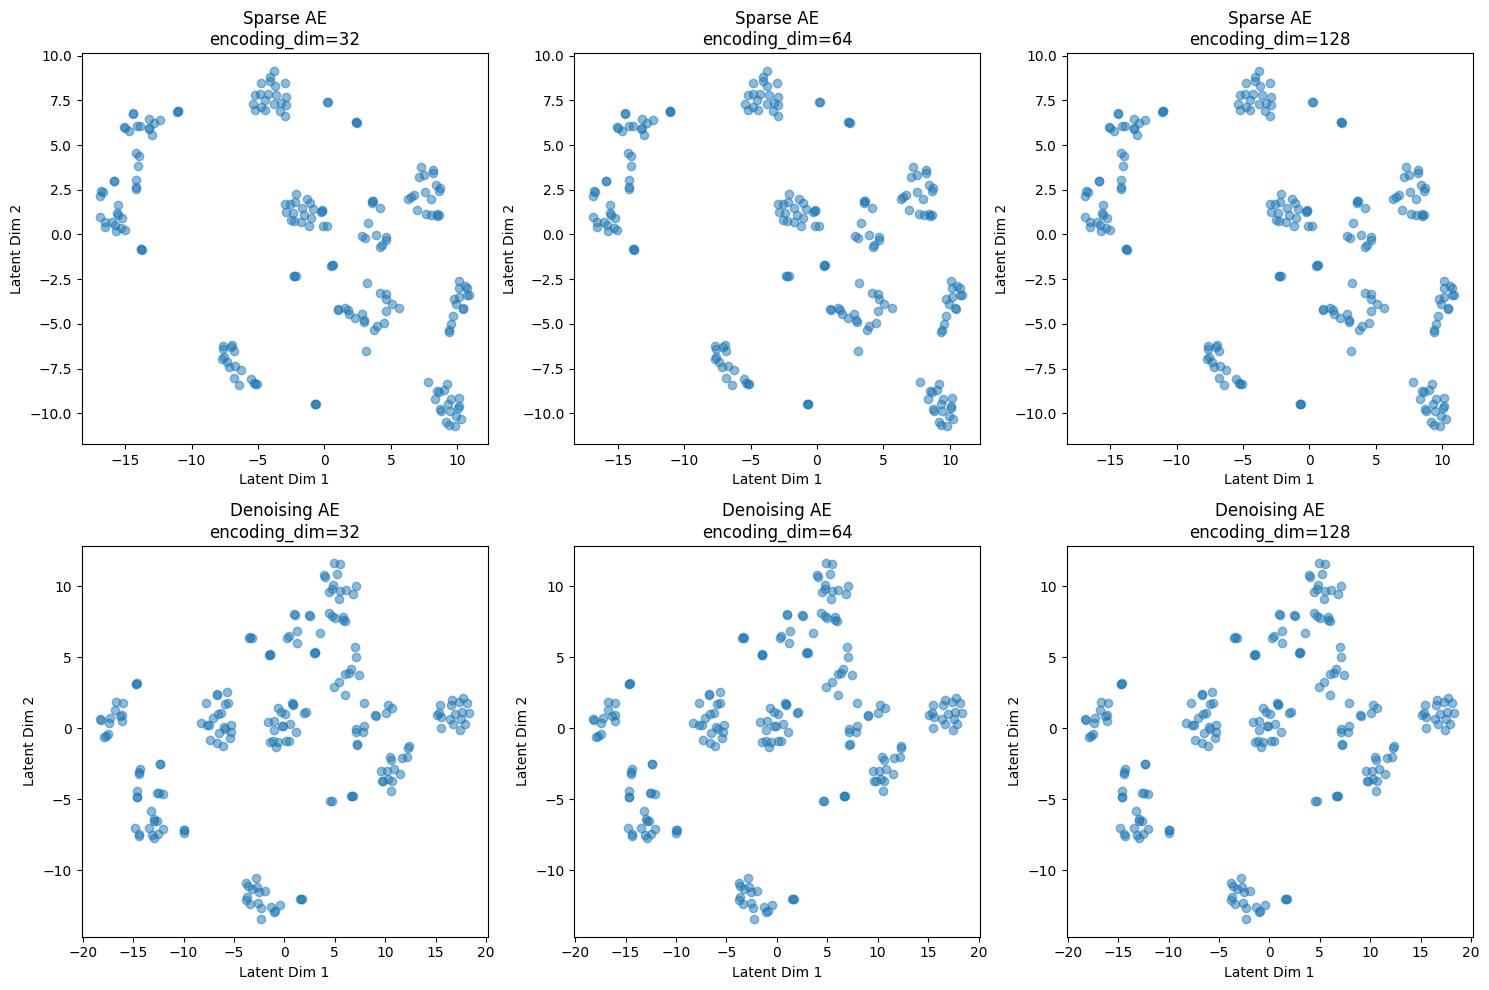

In [4]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from keras.models import Model

# Función para extraer el espacio latente (codificador)
def get_latent_space(autoencoder, X_data):
    encoder = Model(autoencoder.input, autoencoder.layers[1].output)
    return encoder.predict(X_data)

# Aplicar t-SNE al conjunto de entrenamiento
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, (latent_space, params) in enumerate(zip(sparse_latent_spaces, param_combinations)):
    # Obtener el espacio latente para el conjunto de entrenamiento
    latent_space_train = get_latent_space(sparse_ae, X_train)

    # Reducir la dimensionalidad a 2D usando t-SNE
    latent_space_2d = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(latent_space_train)

    # Graficar el espacio latente reducido
    axs[0, i].scatter(latent_space_2d[:, 0], latent_space_2d[:, 1], alpha=0.5)
    axs[0, i].set_title(f'Sparse AE\nencoding_dim={params["encoding_dim"]}')
    axs[0, i].set_xlabel('Latent Dim 1')
    axs[0, i].set_ylabel('Latent Dim 2')

for i, (latent_space, params) in enumerate(zip(denoising_latent_spaces, param_combinations)):
    # Obtener el espacio latente para el conjunto de entrenamiento
    latent_space_train = get_latent_space(denoising_ae, X_train)

    # Reducir la dimensionalidad a 2D usando t-SNE
    latent_space_2d = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(latent_space_train)

    # Graficar el espacio latente reducido
    axs[1, i].scatter(latent_space_2d[:, 0], latent_space_2d[:, 1], alpha=0.5)
    axs[1, i].set_title(f'Denoising AE\nencoding_dim={params["encoding_dim"]}')
    axs[1, i].set_xlabel('Latent Dim 1')
    axs[1, i].set_ylabel('Latent Dim 2')

plt.tight_layout()
plt.show()


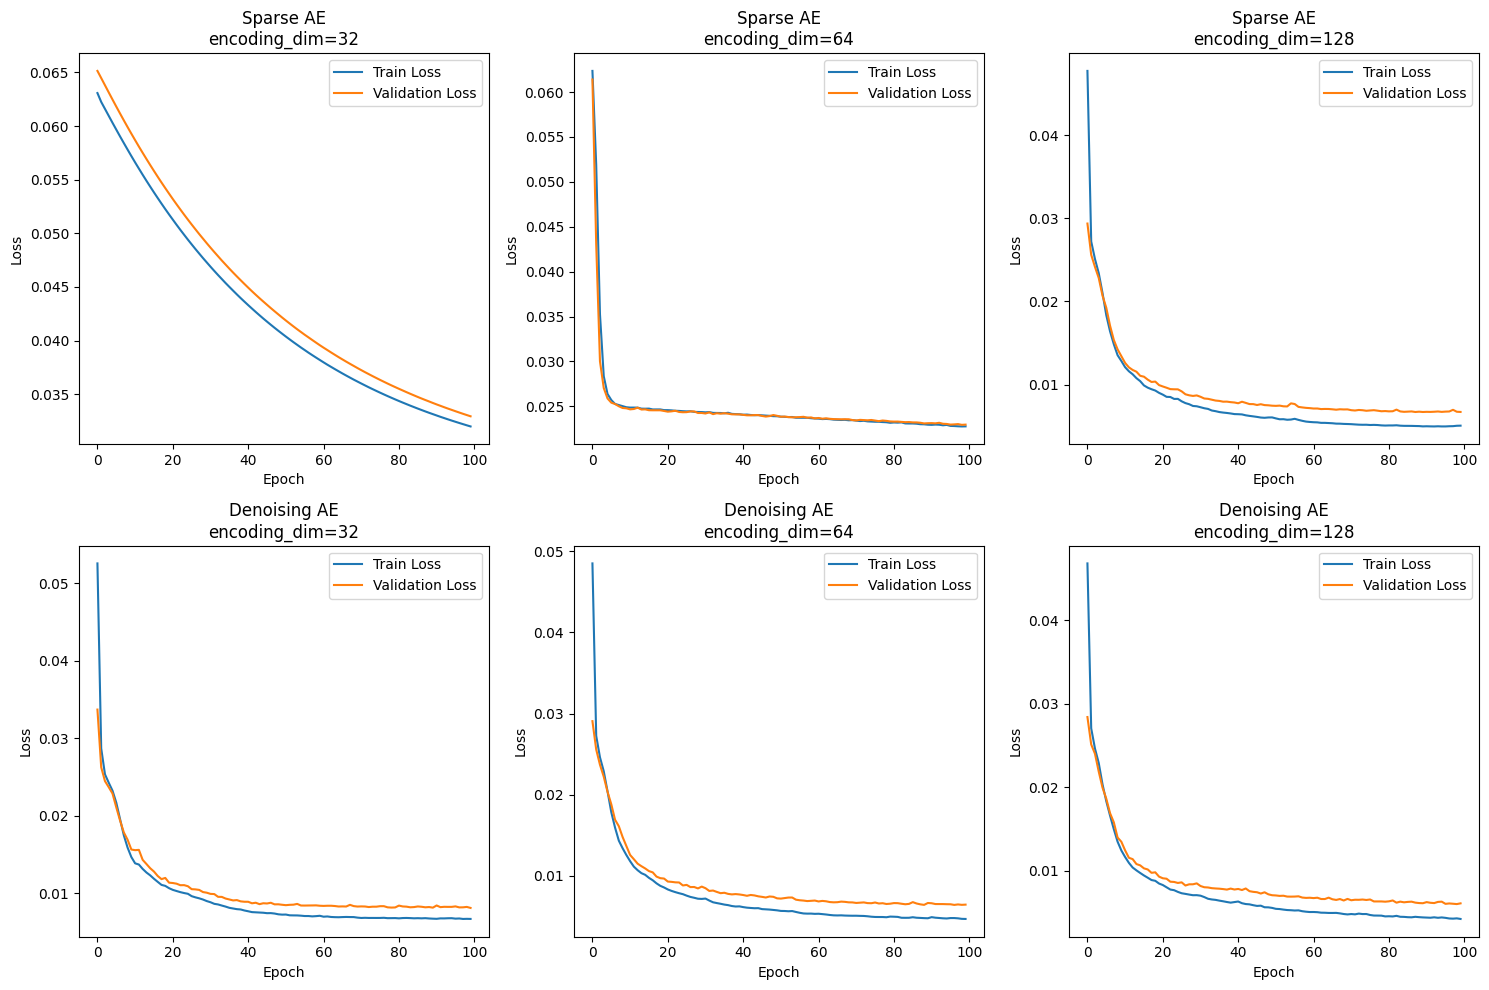

In [9]:
# Graficar la curva de pérdida para entrenamiento y validación
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, history in enumerate(sparse_histories):
    axs[0, i].plot(history.history['loss'], label='Train Loss')
    axs[0, i].plot(history.history['val_loss'], label='Validation Loss')
    axs[0, i].set_title(f'Sparse AE\nencoding_dim={param_combinations[i]["encoding_dim"]}')
    axs[0, i].set_xlabel('Epoch')
    axs[0, i].set_ylabel('Loss')
    axs[0, i].legend()

for i, history in enumerate(denoising_histories):
    axs[1, i].plot(history.history['loss'], label='Train Loss')
    axs[1, i].plot(history.history['val_loss'], label='Validation Loss')
    axs[1, i].set_title(f'Denoising AE\nencoding_dim={param_combinations[i]["encoding_dim"]}')
    axs[1, i].set_xlabel('Epoch')
    axs[1, i].set_ylabel('Loss')
    axs[1, i].legend()

plt.tight_layout()
plt.show()


Evaluando configuración 1:

Evaluando Sparse Autoencoder:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


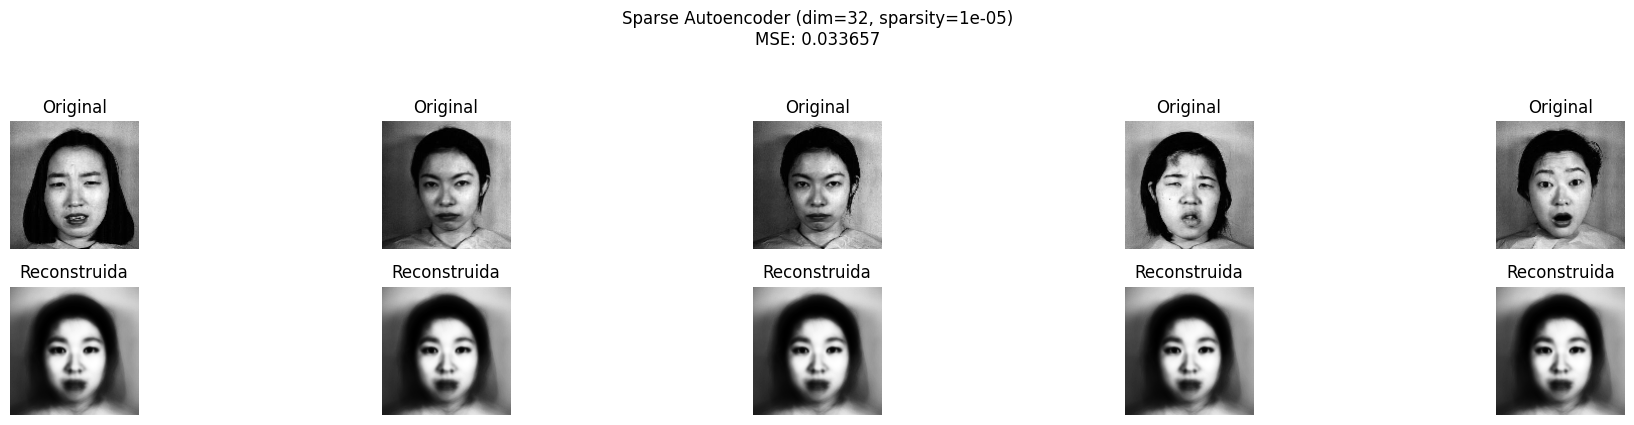


Evaluando Denoising Autoencoder:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


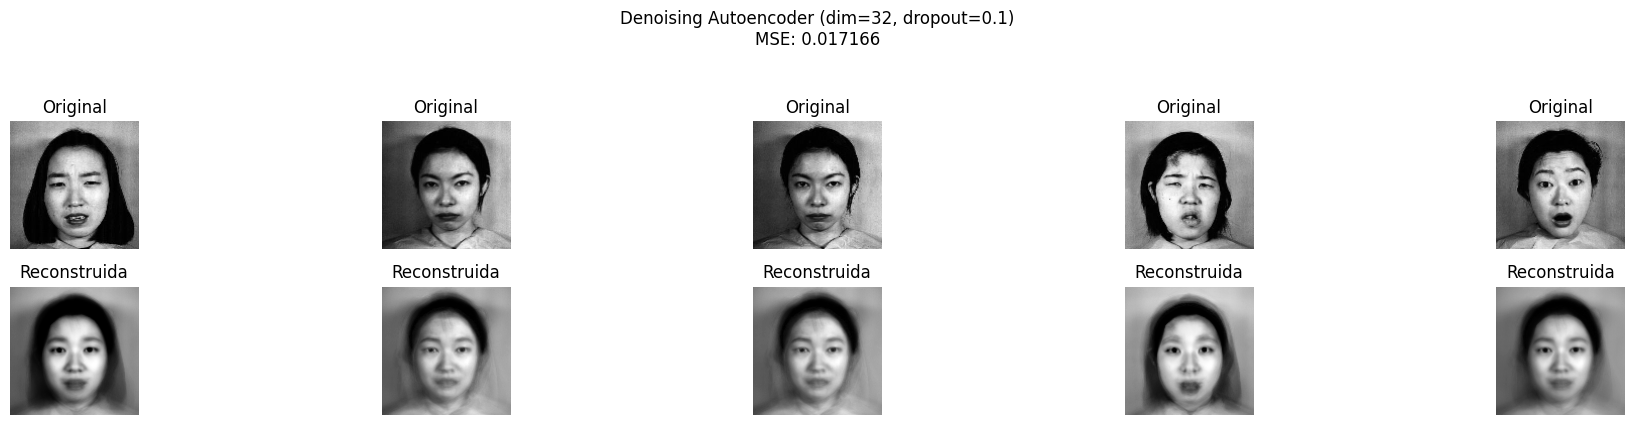


Evaluando configuración 2:

Evaluando Sparse Autoencoder:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


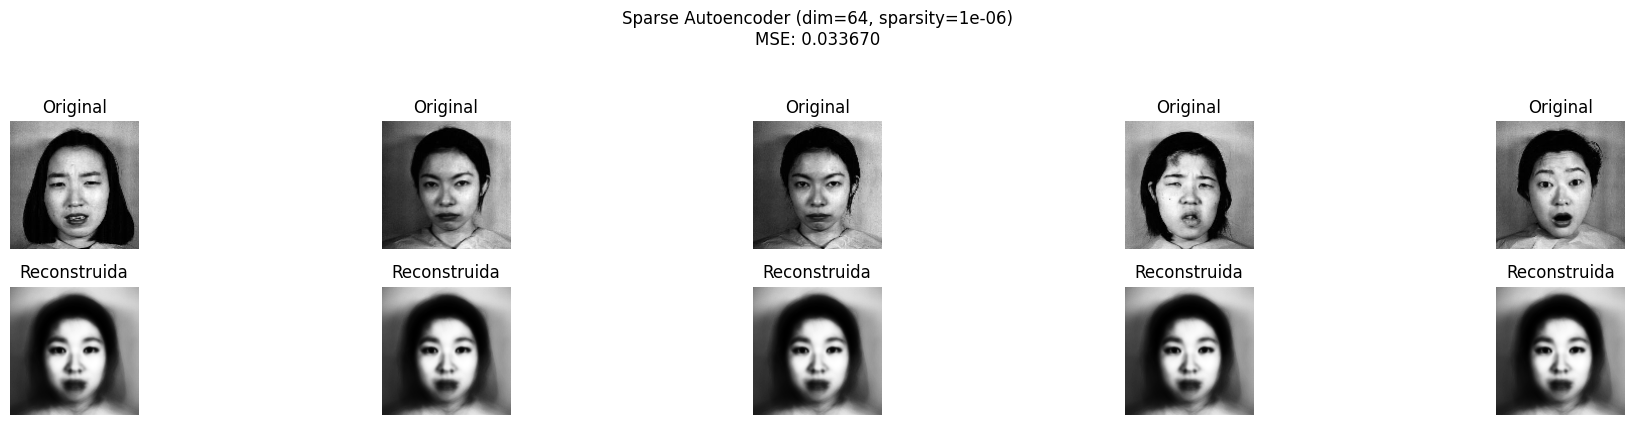


Evaluando Denoising Autoencoder:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


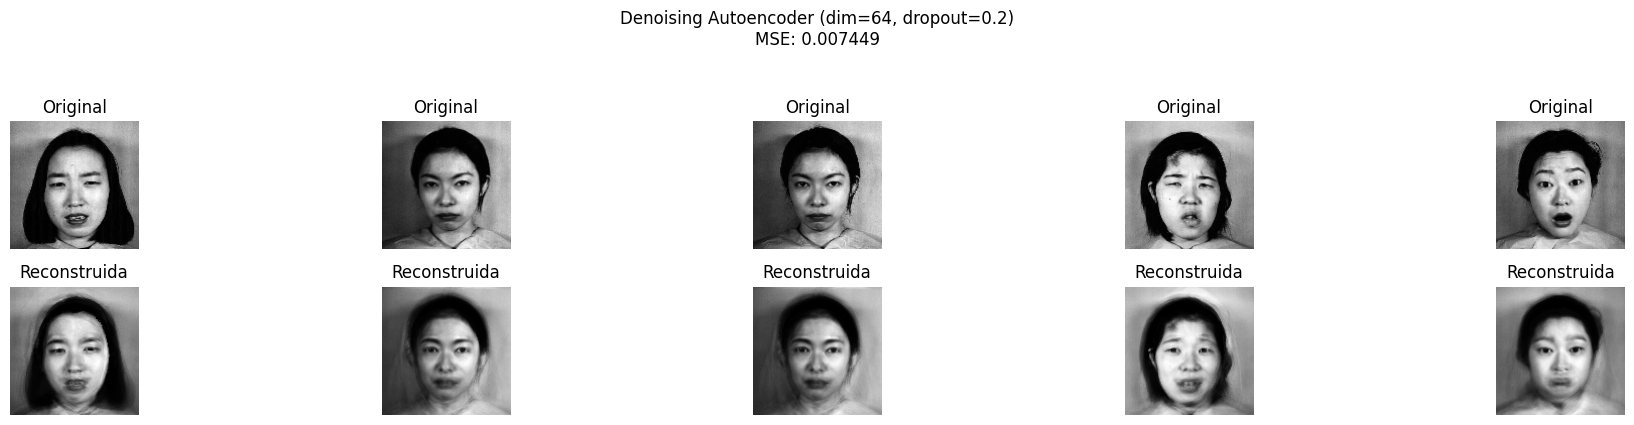


Evaluando configuración 3:

Evaluando Sparse Autoencoder:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


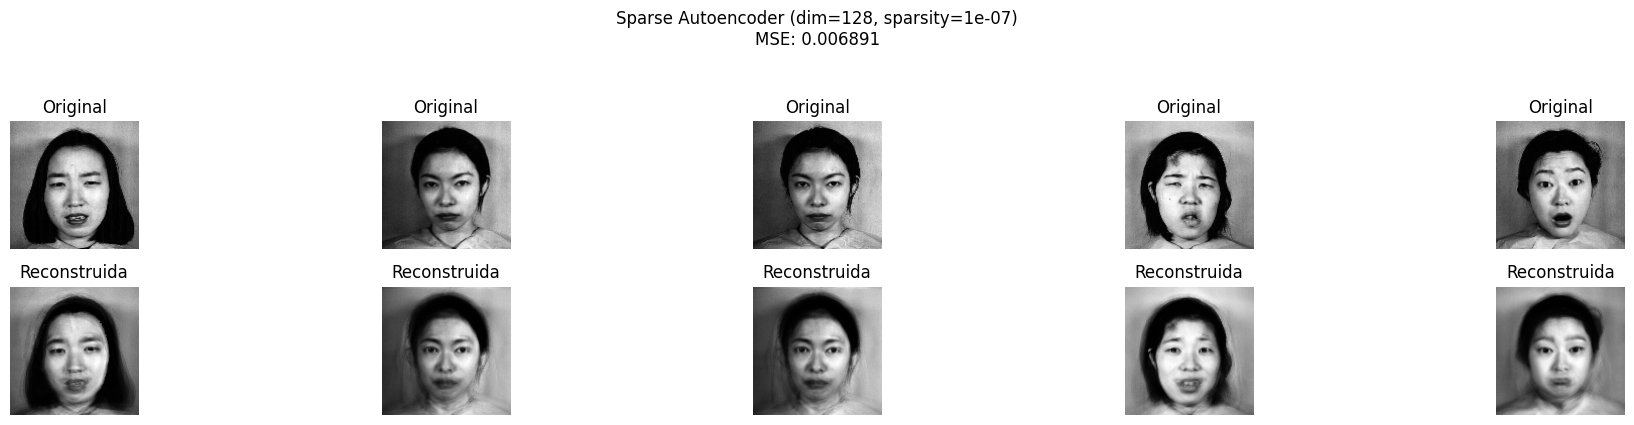


Evaluando Denoising Autoencoder:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


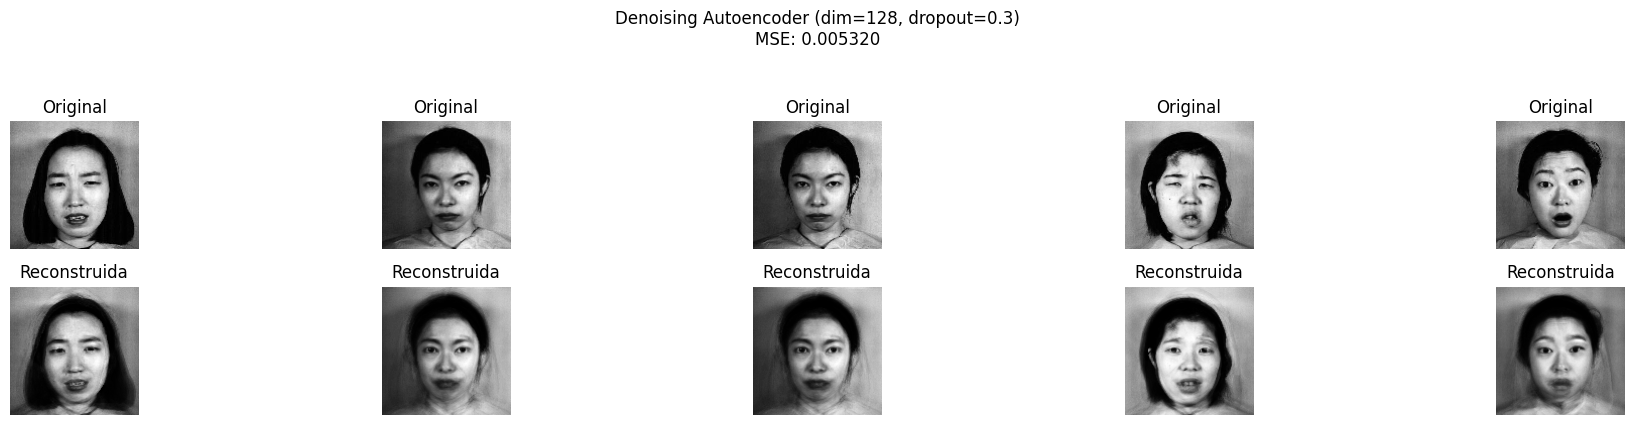

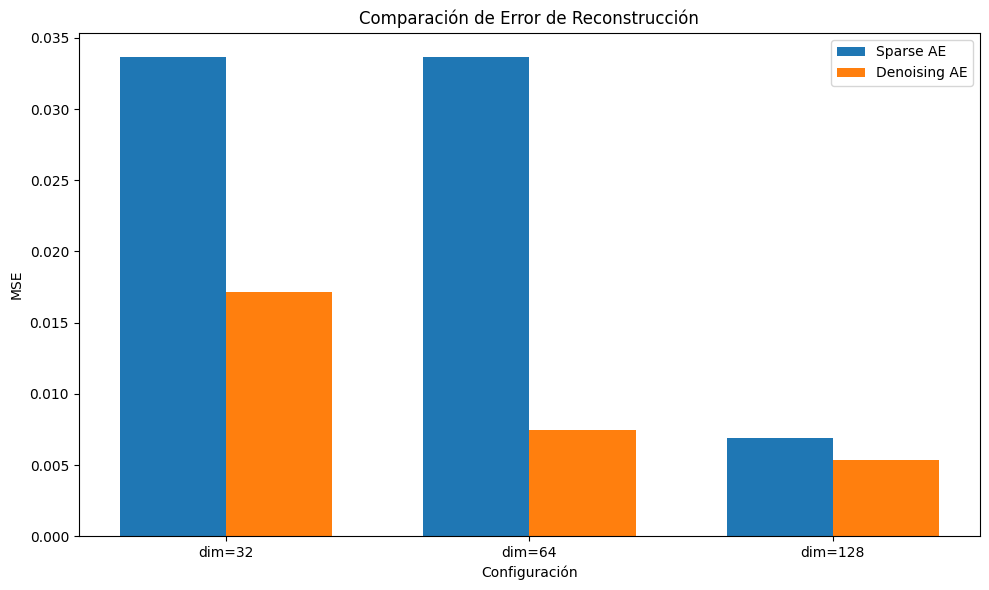

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model

def plot_reconstructions(original_images, reconstructed_images, n_samples=5, title=""):
    plt.figure(figsize=(20, 4))
    for i in range(n_samples):
        # Original
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(original_images[i].reshape(128, 128), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Reconstrucción
        plt.subplot(2, n_samples, i + n_samples + 1)
        plt.imshow(reconstructed_images[i].reshape(128, 128), cmap='gray')
        plt.title('Reconstruida')
        plt.axis('off')

    plt.suptitle(title, y=1.05)
    plt.tight_layout()
    plt.show()

def evaluate_autoencoder(autoencoder, X_test, title):
    reconstructions = autoencoder.predict(X_test)
    mse = mean_squared_error(X_test, reconstructions)
    plot_reconstructions(X_test, reconstructions, title=f"{title}\nMSE: {mse:.6f}")
    return mse

# Definir `param_combinations` aquí si aún no está definido en tu código principal
param_combinations = [
    {'encoding_dim': 32, 'sparsity': 1e-5, 'dropout_rate': 0.1},
    {'encoding_dim': 64, 'sparsity': 1e-6, 'dropout_rate': 0.2},
    {'encoding_dim': 128, 'sparsity': 1e-7, 'dropout_rate': 0.3}
]

sparse_mse = []
denoising_mse = []

for i, params in enumerate(param_combinations):
    print(f"\nEvaluando configuración {i+1}:")

    sparse_ae = build_sparse_autoencoder(X_train.shape[1], params['encoding_dim'], params['sparsity'])
    denoising_ae = build_denoising_autoencoder(X_train.shape[1], params['encoding_dim'], params['dropout_rate'])

    sparse_ae.fit(X_train, X_train, epochs=100, batch_size=16, validation_split=0.2, verbose=0)
    denoising_ae.fit(X_train, X_train, epochs=100, batch_size=16, validation_split=0.2, verbose=0)

    print("\nEvaluando Sparse Autoencoder:")
    mse_sparse = evaluate_autoencoder(sparse_ae, X_test, f"Sparse Autoencoder (dim={params['encoding_dim']}, sparsity={params['sparsity']})")
    sparse_mse.append(mse_sparse)

    print("\nEvaluando Denoising Autoencoder:")
    mse_denoising = evaluate_autoencoder(denoising_ae, X_test, f"Denoising Autoencoder (dim={params['encoding_dim']}, dropout={params['dropout_rate']})")
    denoising_mse.append(mse_denoising)

plt.figure(figsize=(10, 6))
x = np.arange(len(param_combinations))
width = 0.35

plt.bar(x - width / 2, sparse_mse, width, label='Sparse AE')
plt.bar(x + width / 2, denoising_mse, width, label='Denoising AE')

plt.xlabel('Configuración')
plt.ylabel('MSE')
plt.title('Comparación de Error de Reconstrucción')
plt.xticks(x, [f'dim={p["encoding_dim"]}' for p in param_combinations])
plt.legend()
plt.tight_layout()
plt.show()
